## 完成手写数字识别任务的极简方案

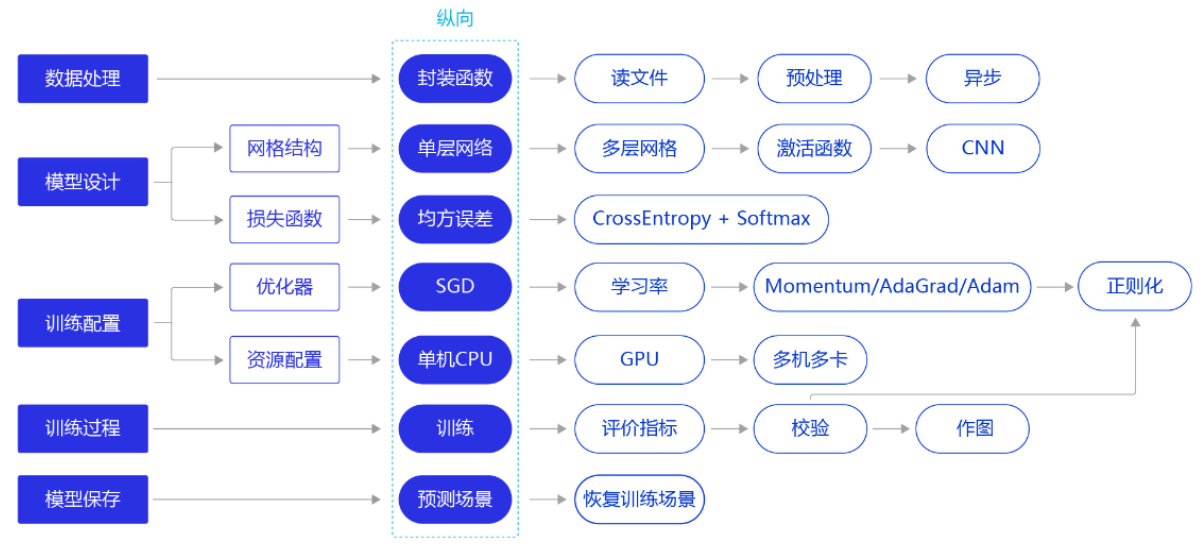

In [1]:
# 加载飞浆和相关的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os

## 数据处理

In [3]:
"""飞浆API

飞浆提供了多个封装好的数据集API，涵盖计算机视觉、自然语言处理、推荐系统等多个领域。
飞浆API支持的常见学术数据集：mnist, cifar, Conll05, imdb, imikolov, movielens, sentiment, uci_housing, wmt14, wmt16
"""

# 读取手写数字MNIST数据训练集
train_dataset = paddle.vision.datasets.MNIST(mode='train')

# 提取第一条数据
train_data0 = np.array(train_dataset[0][0])
train_label0 = np.array(train_dataset[0][1])

print('图像数据形状和对应数据为：', train_data0.shape, train_data0)
print('图像标签形状和对应数据为：', train_label0.shape, train_label0)

图像数据形状和对应数据为： (28, 28) [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253

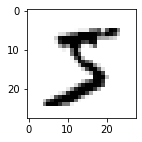

In [5]:
# 显示第一个图像
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
plt.show()

## 模型设计

In [6]:
"""模型设计

在本手写数字识别任务中，模型的输入为784维的数据（28 * 28），输出为1维数据。
"""

# 定义网络结构
class MNIST(paddle.nn.Layer):
    # 初始化
    def __init__(self):
        # 调用父类初始化方法
        super(MNIST, self).__init__()
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

## 训练配置

In [7]:
"""训练配置

训练配置需要先生成模型实例，设置为训练状态，再设置优化算法（使用随机梯度下降SGD）和学习率
"""

# 获取模型实例
model = MNIST()

# 定义训练方法
def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集，batch_size设为16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), batch_size=16, shuffle=True)
    # 定义优化算法，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

## 训练过程

In [8]:
"""训练过程

训练过程采用两层循环嵌套方式，训练完成后需要保存模型参数，以便后续使用。
- 内层循环：负责整个数据集的一次遍历，遍历数据集采用分批次的方式。
- 外层循环：定义遍历数据集的次数，本次训练中外层循环10次，通过参数EPOCH_NUM设置。
"""

# 图像归一化函数，将数据范围[0, 255]的图像归一化到[0, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img / 255
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

In [9]:
# 确保加载的数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

# 获取模型实例
model = MNIST()

# 定义训练方法
def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集，batch_size设为16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), batch_size=16, shuffle=True)
    # 定义优化算法，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    
    # 定义外层循环次数
    EPOCH_NUM = 10
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('float32')
            
            # 前向计算的过程
            predicts = model(images)
            
            # 计算损失
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            # 每训练1000批次的数据，打印当前Loss情况
            if batch_id % 1000 == 0:
                print('epoch_id: {}, batch_id: {}, loss is {}'.format(epoch, batch_id, avg_loss.numpy()))
                
            # 反向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

In [ ]:
# 训练模型
train(model)

# 保存模型参数
paddle.save(model.state_dict(), '../models/mnist.pdparams')

## 模型测试

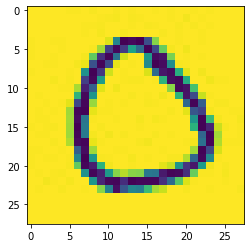

In [15]:
"""模型测试的基本步骤

- 声明实例
- 加载模型：加载训练过程中保存的模型参数。
- 导入数据：将测试样本传入模型，模型的状态设置为校验状态(eval).
- 获取预测结果，取整后作为预测标签输出。
"""

from PIL import Image

# 读取测试图像并显示
img = Image.open(r'../datasets/mnist_example_0.jpg')
plt.imshow(img)
plt.show()

In [16]:
# 将原始图像转为灰度图
img = img.convert('L')

print('原始图像shape: ', np.array(img).shape)

原始图像shape:  (28, 28)


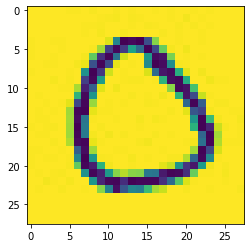

采用后图像shape:  (28, 28)


In [17]:
# 使用Image.ANTIALIAS方式采用原始图片
img = img.resize((28, 28), Image.ANTIALIAS)
plt.imshow(img)
plt.show()

print('采用后图像shape: ', np.array(img).shape)

In [18]:
# 读取一张本地图片，转换成模型输入的格式
def load_image(img_path):
    # 从指定路径读取图像，并转换为灰度图
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28), Image.ANTIALIAS)
    img = np.array(img).reshape(1, -1).astype(np.float32)
    # 图像归一化，保持和数据集的数据范围一致
    img = 1 - img / 255
    return img

In [21]:
# 初始化模型实例
model = MNIST()

# 加载模型参数
param_dict = paddle.load(r'../models/mnist.pdparams')
model.load_dict(param_dict)

# 导入数据
model.eval()
test_img = load_image(r'../datasets/mnist_example_0.jpg')
result = model(paddle.to_tensor(test_img))

print('Result: ', result)
print('本次识别的数字是：', result.numpy().astype('int32'))

Result:  Tensor(shape=[1, 1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[0.93337750]])
本次识别的数字是： [[0]]
